In [1]:
import os
import time
import numpy as np

from simtk import unit
from simtk.openmm import app, LangevinIntegrator
from simtk.openmm.app import PDBFile

import parmed as pmd

from openforcefield.topology import Molecule, Topology
from openforcefield.typing.engines.smirnoff import ForceField

import matplotlib.pyplot as plt
import mpld3

In [2]:
# choose the force field:
# not yet the release version!
openff_forcefield = ForceField('smirnoff99Frosst-1.1.0.offxml')

In [3]:
# function to convert openFF molecule (ligand) to a parmed structure
def ligandToPMD(ligand):
    ligand_positions = ligand.conformers[0]
    
    # Calculate am1bcc charges and fix them such that they add up to zero (4 digit precision)
    try:
        ligand.compute_partial_charges_am1bcc()
    except Exception as e:
        raise Exception('Error in charge calculation for ligand {}: {}'.format(ligand.name, e))
    # Give all atoms unique names so we can export to GROMACS
    for idx, atom in enumerate(ligand.atoms):
        atom.name = f'{atom.element.symbol}{idx}'
    
    # Do not assign H-bond constraints now, instead have ParmEd add them later
    del openff_forcefield._parameter_handlers['Constraints']

    ligand_topology = ligand.to_topology()
    try:
        ligand_system = openff_forcefield.create_openmm_system(ligand_topology, charge_from_molecules=[ligand])
    except Exception as e:
        raise Exception('Error in creating openmm system: {}'.format(e))
    # Create OpenMM Topology from OpenFF Topology
    omm_top = ligand_topology.to_openmm()


    # Convert OpenMM System to a ParmEd structure.
    pmd_structure = pmd.openmm.load_topology(omm_top, ligand_system, ligand_positions)

    return pmd_structure, ligand_topology, ligand_system, ligand_positions

In [4]:
# function for analyzing energy contributions of openMM energies
def forcegroupify(system):
    forcegroups = {}
    for i in range(system.getNumForces()):
        force = system.getForce(i)
        force.setForceGroup(i)
        forcegroups[(type(force)).__name__] = i
    return forcegroups

def getEnergyDecomposition(context, forcegroups):
    energies = {}
    for f, i in forcegroups.items():
        energies[f] = context.getState(getEnergy=True, groups=2**i).getPotentialEnergy()
    energies['TotalPotential'] = context.getState(getEnergy=True).getPotentialEnergy()
    return energies

# Create gromacs topologies and coordinates of simple test molecules

In [5]:
# create simple test molecules
target = 'testmols'
print('=== ' + target + ' ===')
names = ['methane', 'ethane', 'ethanol', 'acetone', 'benzene', 'phenol', 'benzaldehyde']
smiles = ['C', 'CC', 'CCO', 'CC(=O)C', 'c1ccccc1', 'c1ccccc1O', 'c1ccccc1C=O']
for lig, smi in zip(names, smiles):
    print('    ', lig)
    ligand = Molecule.from_smiles(smi)
    ligand.name = lig
    ligand.generate_conformers()
    
    ligPath = 'systems/' + target + '/' + lig 
    ! mkdir -p $ligPath
    ligPath += '/' + lig
    
    # Export sdf file
    ligand.to_file(ligPath+'.sdf', file_format='sdf')
        
    try: 
        pmd_structure, ligand_topology, ligand_system, ligand_positions = ligandToPMD(ligand)
    except Exception as e:
        print('    ' + str(e))
        continue
       
    # Export GROMACS files.
    pmd_structure.save(ligPath+'.top', overwrite=True)
    pmd_structure.save(ligPath+'.gro', overwrite=True)

=== testmols ===
     methane
     ethane
     ethanol
     acetone
     benzene
     phenol
     benzaldehyde


# Convert pdb files to gromacs topologies

In the last version I first converted the pdb files first to sdf with openbabel - let the openFF toolkit (only works with OpenEye) do it on itself.

ATTENTION: this might prone to errors because the pdb files do not have bond information

In [6]:
for target in ['jnk1', 'pde2', 'thrombin']:
    print('=== ' + target + ' ===')
    ligands = ! ls -d "systems/"$target/*/
    for lig in ligands:
        lig = lig.split('/')
        ligPath= 'systems/' + target + '/' + lig[-2] + '/' + lig[-2]
        
        if os.path.isfile(ligPath + '.pdb'):
            print('   ', lig[-2])
            
            # Try to read in PDB file (original), only works with OpenEye
            # Otherwise the SDF file (not original, converted from PDB) is used
            try:
                ligand = Molecule.from_file(ligPath + '.pdb')
                # save as sdf file
                ligand.to_file(ligPath+'.sdf', 'sdf')
            except Exception as e:
                print('    ' + str(e))
                if os.path.isfile(ligPath + '.sdf'):
                    print('    Using the SDF file')
                    ligand = Molecule.from_file(ligPath + '.sdf')
                else:
                    print('    Molecules {} cannot be read in'.format(lig[-2]))
            
            try: 
                pmd_structure, ligand_topology, ligand_system, ligand_positions = ligandToPMD(ligand)
            except Exception as e:
                print('    ' + str(e))
                continue

            # Export GROMACS files.
            pmd_structure.save(ligPath+'.top', overwrite=True)
            pmd_structure.save(ligPath+'.gro', overwrite=True)

=== jnk1 ===
    lig_17124-1
    lig_18624-1
    lig_18625-1
    lig_18626-1
    lig_18627-1
    lig_18628-1
    lig_18629-1
    lig_18630-1
    lig_18631-1
    lig_18632-1
    lig_18633-1
    lig_18634-1
    lig_18635-1
    lig_18636-1
    lig_18637-1
    lig_18638-1
    lig_18639-1
    lig_18652-1
    lig_18658-1
    lig_18659-1
    lig_18660-1
=== pde2 ===
    lig_43249674
    Unable to make OFFMol from OEMol: OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name:  C6 , idx: 10, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name:  C1 , idx: 9, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name:  C14, idx: 11, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name:  N5 , idx: 12, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name:  H6 , idx: 48, aromatic: False, chiral: False

   

    lig_49396360
    Unable to make OFFMol from OEMol: OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name:  C6 , idx: 14, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name:  C1 , idx: 13, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name:  C14, idx: 15, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name:  N5 , idx: 16, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name:  H6 , idx: 57, aromatic: False, chiral: False

    Using the SDF file
    lig_49580115
    Unable to make OFFMol from OEMol: OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name:  C6 , idx: 14, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name:  C1 , idx: 13, aromatic: False, chiral: False
bond order: 1, chi

# Use SDF files with coordinates of PDB files

This only works for the PDE2 ligands. SDF file of supporting information of https://www.nature.com/articles/s41598-018-23039-5
Here, sometimes warnings ("duplicate atom") pop up (not reproducible). To be investigated.

In [10]:
print('=== pde2_sdf ===')
target = 'pde2_sdf'
ligands = Molecule.from_file('systems/pde2_sdf/4D08_ligands_input.sdf', 'sdf')
for ligand in ligands:
    # try to find a pdb matching the ligand from the SDF file
    pdbtarget = 'pde2'
    pdbligands = ! ls -d 'systems/'$pdbtarget/*/
    for pdblig in pdbligands:
        pdblig = pdblig.split('/')
        pdbligPath = 'systems/' + pdbtarget + '/' + pdblig[-2] + '/' + pdblig[-2]
        
        if os.path.isfile(pdbligPath+'.pdb'):
            pdb = app.PDBFile(pdbligPath + ".pdb")
            openmm_topology = pdb.topology
            try:
                ligand_topology = Topology.from_openmm(openmm_topology, unique_molecules=[ligand])
                print('    {}    {}'.format(ligand.name, pdblig[-2]))
                break
            except:
                continue
    else:
        print('PDB coordinates not found')
    
    
    # the following try statement is a custom version of the function ligandToPMD above
    try:
        # get pdb positions
        ligand_positions = pdb.getPositions()
            
        # set ligand conformer to pdb positions, Attention: This only works if the order of atoms is the same in the pdb file and the ligand class
        ligand.conformers[0] = unit.Quantity(np.array(ligand_positions.value_in_unit(unit.angstrom)), unit.angstrom)
            
        # Calculate am1bcc charges and fix them such that they add up to zero (4 digit precision)
        try:
            ligand.compute_partial_charges_am1bcc()
        except Exception as e:
            raise Exception('Error in charge calculation for ligand {}: {}'.format(ligand.name, e))
        # Give all atoms unique names so we can export to GROMACS
        for idx, atom in enumerate(ligand.atoms):
            atom.name = f'{atom.element.symbol}{idx}'
            ligand_topology.atom(idx).atom.name = atom.name

        # Do not assign H-bond constraints now, instead have ParmEd add them later
        del openff_forcefield._parameter_handlers['Constraints']

        try:
            ligand_system = openff_forcefield.create_openmm_system(ligand_topology, charge_from_molecules=[ligand])
        except Exception as e:
            raise Exception('Error in creating openmm system: {}'.format(e))
        # Create OpenMM Topology from OpenFF Topology
        omm_top = ligand_topology.to_openmm()


        # Convert OpenMM System to a ParmEd structure.
        pmd_structure = pmd.openmm.load_topology(omm_top, ligand_system, ligand_positions)
    except Exception as e:
        print('    ' + str(e))
        continue

    # Output path.
    ligPath = 'systems/' + target + '/' + pdblig[-2]
    ! mkdir -p $ligPath
    ligPath = 'systems/' + target + '/' + pdblig[-2] + '/' + pdblig[-2]
        
    # Export single SDF file
    ligand.to_file(ligPath+'.sdf', file_format='sdf')
        
    # Export GROMACS files.        
    pmd_structure.save(ligPath+'.top', overwrite=True)
    pmd_structure.save(ligPath+'.gro', overwrite=True)

=== pde2_sdf ===
    2    lig_43249674
    4    lig_49137530
    6    lig_48009208
    7    lig_48022468
    8    lig_48168913
    9    lig_49137374
    10    lig_48271249
    11    lig_49220392
    12    lig_49580115
    13    lig_49220548
    14    lig_49396360
    15    lig_49175828
    16    lig_49072088
    17    lig_49582468
    18    lig_49932129
    19    lig_49932714
    20    lig_49585367
    21    lig_49175789
    22    lig_50181001
    23    lig_50107616
    24    lig_49582390


# Run single point energies and minimizations in openMM and Gromacs

In [11]:
# initialize dicts to store gromacs and openMM energies
gromacsEnergies = {}
openmmEnergies = {}
gromacsMinimizedEnergies = {}
openmmMinimizedEnergies = {}

#### openMM

In [12]:
 # run it in openMM
for target in ['testmols',  'jnk1', 'pde2', 'thrombin', 'pde2_sdf']:
    openmmEnergies[target] = {}
    openmmMinimizedEnergies[target] = {}
    print('=' * 60)
    print('=== ' + target + ' ===')
    print('=' * 60)
    ligands = ! ls -d 'systems/'$target/*/
    for lig in ligands:
        lig = lig.split('/')
        ligPath = 'systems/' + target + '/' + lig[-2] + '/' + lig[-2]
        
        if os.path.isfile(ligPath+'.gro') and os.path.isfile(ligPath+'.top'):
            print('-' * 60)
            print('--- ' + lig[-2] + ' ---')
            print('-' * 60)
            gro_positions = pmd.load_file(ligPath + '.gro')
            
            ligand_topology = pmd.load_file(ligPath + '.top', box = gro_positions.box)
            ligand_system = ligand_topology.createSystem(nonbondedMethod = app.NoCutoff, removeCMMotion = False)

            integrator = LangevinIntegrator(300*unit.kelvin, 
                            1/unit.picosecond, 
                            0.002*unit.picoseconds)

             
            simulation = app.Simulation(ligand_topology, ligand_system, integrator)
        
            simulation.context.setPositions(gro_positions.positions)
        
            energies = getEnergyDecomposition(simulation.context, forcegroupify(ligand_system))
            openmmEnergies[target][lig[-2]] = energies
            print('     Estart : {}'.format(energies['TotalPotential']))
    
            simulation.minimizeEnergy()
            minimized_coords = simulation.context.getState(getPositions=True).getPositions()
            
            energies = getEnergyDecomposition(simulation.context, forcegroupify(ligand_system))
            openmmMinimizedEnergies[target][lig[-2]] = energies
            print('     Emin   : {}'.format(energies['TotalPotential']))

=== testmols ===
------------------------------------------------------------
--- acetone ---
------------------------------------------------------------
     Estart : -67.72282506213872 kJ/mol
     Emin   : -74.78288823448784 kJ/mol
------------------------------------------------------------
--- benzaldehyde ---
------------------------------------------------------------
     Estart : 60.322974597235095 kJ/mol
     Emin   : 55.65236754732132 kJ/mol
------------------------------------------------------------
--- benzene ---
------------------------------------------------------------
     Estart : 25.620914170270048 kJ/mol
     Emin   : 23.4687371657219 kJ/mol
------------------------------------------------------------
--- ethane ---
------------------------------------------------------------
     Estart : 6.507785203224147 kJ/mol
     Emin   : 4.330234330612461 kJ/mol
------------------------------------------------------------
--- ethanol ---
-----------------------------------

     Estart : 420.23988529143753 kJ/mol
     Emin   : 304.32385395052404 kJ/mol
------------------------------------------------------------
--- lig_49220392 ---
------------------------------------------------------------
     Estart : 432.48079420045576 kJ/mol
     Emin   : 318.5872113917493 kJ/mol
------------------------------------------------------------
--- lig_49220548 ---
------------------------------------------------------------
     Estart : 443.29067761076976 kJ/mol
     Emin   : 331.1880863930054 kJ/mol
------------------------------------------------------------
--- lig_49396360 ---
------------------------------------------------------------
     Estart : 452.0418432513597 kJ/mol
     Emin   : 354.5374646617523 kJ/mol
------------------------------------------------------------
--- lig_49580115 ---
------------------------------------------------------------
     Estart : 455.8447004681834 kJ/mol
     Emin   : 344.54179505554515 kJ/mol
---------------------------------

     Emin   : 504.384223620719 kJ/mol
------------------------------------------------------------
--- lig_49582468 ---
------------------------------------------------------------
     Estart : 296.9138132623247 kJ/mol
     Emin   : 176.09868952532895 kJ/mol
------------------------------------------------------------
--- lig_49585367 ---
------------------------------------------------------------
     Estart : 491.44385552231756 kJ/mol
     Emin   : 388.34791151025576 kJ/mol
------------------------------------------------------------
--- lig_49932129 ---
------------------------------------------------------------
     Estart : 355.41177165417395 kJ/mol
     Emin   : 251.76776325909145 kJ/mol
------------------------------------------------------------
--- lig_49932714 ---
------------------------------------------------------------
     Estart : 430.7851921544668 kJ/mol
     Emin   : 329.3485841729238 kJ/mol
------------------------------------------------------------
--- lig_5010

#### Gromacs

Run Gromacs to get energies
Needed to have some sleep times between the system calls because writing of files was not yet finished.
Important to have the option -maxwarn 1 in grompp, because Gromacs sometimes gives warnings about unconstrained quickly oscillating bonds and consequently does not write files. It is important to turn of constraints in the Gromacs input files.

In [13]:
for target in ['testmols',  'jnk1', 'pde2', 'thrombin', 'pde2_sdf']:
    gromacsEnergies[target] = {}
    gromacsMinimizedEnergies[target] = {}
    print('=' * 60)
    print('=== ' + target + ' ===')
    print('=' * 60)
    ligands = ! ls -d 'systems/'$target/*/
    for lig in ligands:
        lig = lig.split('/')
        ligPath = 'systems/' + target + '/' + lig[-2] + '/' + lig[-2]
        
        if os.path.isfile(ligPath+'.gro') and os.path.isfile(ligPath+'.top'):
            print('-' * 60)
            print('--- ' + lig[-2] + ' ---')
            print('-' * 60)
            dir = 'systems/' + target + '/' + lig[-2]
            ! rm -f $dir/\#*
            
            # single point energy of starting structure
            energies = ''
            count = 0
            while not energies and count < 10:
                print('    Calculate single-point energy ...')
                os.system("gmx grompp -f ./input/gromacs/md.mdp -c {}.gro -p {}.top -o {}_md.tpr -maxwarn 1 &> {}_grompp.out".format(ligPath, ligPath, ligPath, ligPath))
                time.sleep(2)
                os.system("gmx mdrun  -s {}_md.tpr -rerun {}.gro -e {}.edr -g {}.log &> {}_mdrun.out".format(ligPath, ligPath, ligPath, ligPath, ligPath))
                time.sleep(2)
                energies = ! cat $ligPath'.log' | grep -A 4 "Energies"
                count += 1
            ene_dict = {'Bond': 0.0, 'Angle': 0.0, 'Proper Dih.': 0.0, 'LJ-14': 0.0, 'Coulomb-14': 0.0, 'LJ (SR)': 0.0, 'Coulomb (SR)': 0.0, 'Potential': 0.0}
            for i in range(int((len(energies)-1)/2)):
                keys = [s.strip() for s in energies[1+i*2].split('  ') if s]
                values = energies[2+i*2].split()
                for key, val in zip(keys, values):
                    ene_dict[key] = float(val)
            print('    ' + str(ene_dict))
            gromacsEnergies[target][lig[-2]] = ene_dict
                        
            # energy minimization
            minEnergies = ''
            count = 0
            while not minEnergies and count < 10:
                print('    Energy minimize ligand ...')
                os.system("gmx grompp -f ./input/gromacs/minim.mdp -c {}.gro -p {}.top -o {}_em.tpr -maxwarn 1 &> {}_grompp_em.out".format(ligPath, ligPath, ligPath, ligPath))
                os.system("gmx mdrun  -deffnm {}_em &> {}_mdrun_em.out".format(ligPath, ligPath))
                time.sleep(2)
                # getting the last energies entry
                minEnergies = ! tac $ligPath'_em.log' | grep -m 1 -B 4 "Energies" | tac 
                count += 1
            
            minEne_dict = {'Bond': 0.0, 'Angle': 0.0, 'Proper Dih.': 0.0, 'LJ-14': 0.0, 'Coulomb-14': 0.0, 'LJ (SR)': 0.0, 'Coulomb (SR)': 0.0, 'Potential': 0.0}
            for i in range(int((len(minEnergies)-1)/2)):
                keys = [s.strip() for s in minEnergies[1+i*2].split('  ') if s]
                values = minEnergies[2+i*2].split()
                for key, val in zip(keys, values):
                    minEne_dict[key] = float(val)
            print('    ' + str(minEne_dict))
            gromacsMinimizedEnergies[target][lig[-2]] = minEne_dict

=== testmols ===
------------------------------------------------------------
--- acetone ---
------------------------------------------------------------
    Calculate single-point energy ...
    {'Bond': 1.11794, 'Angle': 1.9543, 'Proper Dih.': 22.0969, 'LJ-14': 2.50001, 'Coulomb-14': -111.012, 'LJ (SR)': 0.837291, 'Coulomb (SR)': 14.7823, 'Potential': -67.7228}
    Energy minimize ligand ...
    {'Bond': 1.11794, 'Angle': 1.9543, 'Proper Dih.': 22.0969, 'LJ-14': 2.50001, 'Coulomb-14': -111.012, 'LJ (SR)': 0.837291, 'Coulomb (SR)': 14.7823, 'Potential': 0.0, 'Potential Pressure (bar)': -67.7228}
------------------------------------------------------------
--- benzaldehyde ---
------------------------------------------------------------
    Calculate single-point energy ...
    {'Bond': 2.40253, 'Angle': 1.35771, 'Proper Dih.': 0.0204156, 'LJ-14': 18.43, 'Coulomb-14': 46.5483, 'LJ (SR)': -0.756043, 'Coulomb (SR)': -7.67992, 'Potential': 60.323}
    Energy minimize ligand ...
    {'Bon

    {'Bond': 5.17614, 'Angle': 34.225, 'Proper Dih.': 26.2613, 'LJ-14': 58.4366, 'Coulomb-14': -2742.07, 'LJ (SR)': -16.0727, 'Coulomb (SR)': 1521.69, 'Potential': 0.0, 'Potential Pressure (bar)': -1112.36}
------------------------------------------------------------
--- lig_18630-1 ---
------------------------------------------------------------
    Calculate single-point energy ...
    {'Bond': 16.9695, 'Angle': 39.1227, 'Proper Dih.': 25.4189, 'LJ-14': 59.9933, 'Coulomb-14': -2723.14, 'LJ (SR)': -15.9702, 'Coulomb (SR)': 1505.18, 'Potential': -1092.43}
    Energy minimize ligand ...
    {'Bond': 5.74766, 'Angle': 33.6483, 'Proper Dih.': 25.7154, 'LJ-14': 59.21, 'Coulomb-14': -2722.78, 'LJ (SR)': -15.8787, 'Coulomb (SR)': 1505.67, 'Potential': 0.0, 'Potential Pressure (bar)': -1108.67}
------------------------------------------------------------
--- lig_18631-1 ---
------------------------------------------------------------
    Calculate single-point energy ...
    {'Bond': 24.5539,

    {'Bond': 12.693, 'Angle': 64.2133, 'Proper Dih.': 39.6176, 'LJ-14': 64.1862, 'Coulomb-14': -3359.46, 'LJ (SR)': -18.545, 'Coulomb (SR)': 1635.76, 'Potential': 0.0, 'Potential Pressure (bar)': -1561.54}
=== pde2 ===
------------------------------------------------------------
--- lig_43249674 ---
------------------------------------------------------------
    Calculate single-point energy ...
    {'Bond': 47.3782, 'Angle': 119.246, 'Proper Dih.': 30.0847, 'LJ-14': 75.0704, 'Coulomb-14': 291.786, 'LJ (SR)': -25.9425, 'Coulomb (SR)': -100.92, 'Potential': 436.703}
    Energy minimize ligand ...
    {'Bond': 9.59608, 'Angle': 103.285, 'Proper Dih.': 30.4682, 'LJ-14': 69.4695, 'Coulomb-14': 291.113, 'LJ (SR)': -26.4468, 'Coulomb (SR)': -99.7371, 'Potential': 0.0, 'Potential Pressure (bar)': 377.749}
------------------------------------------------------------
--- lig_48009208 ---
------------------------------------------------------------
    Calculate single-point energy ...
    {'Bo

    {'Bond': 51.9837, 'Angle': 128.567, 'Proper Dih.': 42.3404, 'LJ-14': 77.0624, 'Coulomb-14': 319.55, 'LJ (SR)': -27.6098, 'Coulomb (SR)': -136.049, 'Potential': 455.845}
    Energy minimize ligand ...
    {'Bond': 12.0074, 'Angle': 112.567, 'Proper Dih.': 42.4455, 'LJ-14': 73.9936, 'Coulomb-14': 318.34, 'LJ (SR)': -27.4605, 'Coulomb (SR)': -135.111, 'Potential': 0.0, 'Potential Pressure (bar)': 396.782}
------------------------------------------------------------
--- lig_49582390 ---
------------------------------------------------------------
    Calculate single-point energy ...
    {'Bond': 58.077, 'Angle': 140.845, 'Proper Dih.': 82.7378, 'LJ-14': 79.1168, 'Coulomb-14': 367.265, 'LJ (SR)': -29.4614, 'Coulomb (SR)': -161.951, 'Potential': 637.691, 'Improper Dih.': 101.062}
    Energy minimize ligand ...
    {'Bond': 11.9604, 'Angle': 115.917, 'Proper Dih.': 83.0589, 'LJ-14': 75.9241, 'Coulomb-14': 365.418, 'LJ (SR)': -29.3674, 'Coulomb (SR)': -160.908, 'Potential': 0.0, 'Improper

    Calculate single-point energy ...
    {'Bond': 9.4393, 'Angle': 37.6151, 'Proper Dih.': 68.9108, 'LJ-14': 42.3017, 'Coulomb-14': 987.928, 'LJ (SR)': -33.4057, 'Coulomb (SR)': -773.991, 'Potential': 338.799}
    Energy minimize ligand ...
    {'Bond': 9.12908, 'Angle': 31.5846, 'Proper Dih.': 68.7099, 'LJ-14': 43.6332, 'Coulomb-14': 983.386, 'LJ (SR)': -33.1066, 'Coulomb (SR)': -772.882, 'Potential': 0.0, 'Potential Pressure (bar)': 330.454}
------------------------------------------------------------
--- lig_6a ---
------------------------------------------------------------
    Calculate single-point energy ...
    {'Bond': 9.41641, 'Angle': 37.6977, 'Proper Dih.': 69.0777, 'LJ-14': 44.8535, 'Coulomb-14': 988.436, 'LJ (SR)': -32.5272, 'Coulomb (SR)': -779.487, 'Potential': 337.467}
    Energy minimize ligand ...
    {'Bond': 9.29067, 'Angle': 31.6705, 'Proper Dih.': 68.9093, 'LJ-14': 45.9308, 'Coulomb-14': 984.136, 'LJ (SR)': -32.6625, 'Coulomb (SR)': -778.712, 'Potential': 0.0, '

    Calculate single-point energy ...
    {'Bond': 60.2339, 'Angle': 127.506, 'Proper Dih.': 47.8157, 'LJ-14': 81.9558, 'Coulomb-14': 258.081, 'LJ (SR)': -25.9723, 'Coulomb (SR)': -129.9, 'Potential': 419.72}
    Energy minimize ligand ...
    {'Bond': 11.3325, 'Angle': 114.644, 'Proper Dih.': 48.0122, 'LJ-14': 76.8584, 'Coulomb-14': 257.361, 'LJ (SR)': -26.5328, 'Coulomb (SR)': -128.649, 'Potential': 0.0, 'Potential Pressure (bar)': 353.026}
------------------------------------------------------------
--- lig_49220392 ---
------------------------------------------------------------
    Calculate single-point energy ...
    {'Bond': 60.5761, 'Angle': 126.648, 'Proper Dih.': 39.2396, 'LJ-14': 78.6108, 'Coulomb-14': 301.733, 'LJ (SR)': -26.618, 'Coulomb (SR)': -147.84, 'Potential': 432.349}
    Energy minimize ligand ...
    {'Bond': 11.111, 'Angle': 114.114, 'Proper Dih.': 39.3251, 'LJ-14': 73.8962, 'Coulomb-14': 301.174, 'LJ (SR)': -26.9858, 'Coulomb (SR)': -146.649, 'Potential': 0.0, 

# Summarize results

#### Single point energies
The PeriodicTorsionForce of openMM is sometimes split up to 'Proper Dih.' and 'Improper Dih.' energies in Gromacs. A higher precision comparison does not make sense because the Gromacs values only have 6 digit precision.

In [34]:
energies={}
differing_molecules = []
print('    {:20s}: {:15s}    {:15s}    {:15s}'.format('Energy contrib', 'openMM', 'Gromacs', 'Difference'))
for target in ['testmols', 'jnk1', 'pde2', 'pde2_sdf', 'thrombin']:
    print('=== ' + target + ' ===')
    energies[target] = {}
    for key in openmmEnergies[target].keys():
        print(key)
        energies[target][key] = {}
        for kk, ene in openmmEnergies[target][key].items():
            if kk == "NonbondedForce":
                gromacs_ene = sum([gromacsEnergies[target][key][x] for x in ['LJ-14', 'Coulomb-14', 'LJ (SR)', 'Coulomb (SR)']])
            elif kk == 'PeriodicTorsionForce':
                gromacs_ene = gromacsEnergies[target][key]['Proper Dih.']
                if 'Improper Dih.' in gromacsMinimizedEnergies[target][key].keys():
                    print('    {:20s}: {:8.2f}    {:8.2f}    {:8.2f}'.format('ImproperTorsionForce', 0.0, gromacsMinimizedEnergies[target][key]['Improper Dih.'], -gromacsMinimizedEnergies[target][key]['Improper Dih.']))
            elif kk == 'HarmonicAngleForce':
                gromacs_ene = gromacsEnergies[target][key]['Angle']
            elif kk == 'HarmonicBondForce':
                gromacs_ene = gromacsEnergies[target][key]['Bond']
            elif kk == 'TotalPotential':
                gromacs_ene = gromacsEnergies[target][key]['Potential']
            else:
                gromacs_ene = 0.0
                print('Error: OpenMM Energy not known: ' + kk)
            totdiff = ene.value_in_unit(unit.kilojoules_per_mole)-gromacs_ene
            if np.fabs(totdiff) > 1e-2:
                differing_molecules.append([target, key])
            energies[target][key][kk]=np.array([ene.value_in_unit(unit.kilojoules_per_mole), gromacs_ene, ene.value_in_unit(unit.kilojoules_per_mole)-gromacs_ene])
            print('    {:20s}: {:15.5e}    {:15.5e}    {:15.5e}'.format(kk, ene.value_in_unit(unit.kilojoules_per_mole), gromacs_ene, ene.value_in_unit(unit.kilojoules_per_mole)-gromacs_ene))

    Energy contrib      : openMM             Gromacs            Difference     
=== testmols ===
acetone
    HarmonicBondForce   :     1.11794e+00        1.11794e+00        2.12339e-07
    HarmonicAngleForce  :     1.95430e+00        1.95430e+00       -9.83723e-07
    PeriodicTorsionForce:     2.20969e+01        2.20969e+01        2.31354e-05
    NonbondedForce      :    -9.28920e+01       -9.28924e+01        4.11574e-04
    TotalPotential      :    -6.77228e+01       -6.77228e+01       -2.50621e-05
benzaldehyde
    HarmonicBondForce   :     2.40253e+00        2.40253e+00       -2.67913e-06
    HarmonicAngleForce  :     1.35771e+00        1.35771e+00       -2.71367e-06
    PeriodicTorsionForce:     2.04163e-02        2.04156e-02        7.47374e-07
    NonbondedForce      :     5.65423e+01        5.65423e+01       -1.33573e-05
    TotalPotential      :     6.03230e+01        6.03230e+01       -2.54028e-05
benzene
    HarmonicBondForce   :     8.82485e-01        8.82484e-01        7.3021

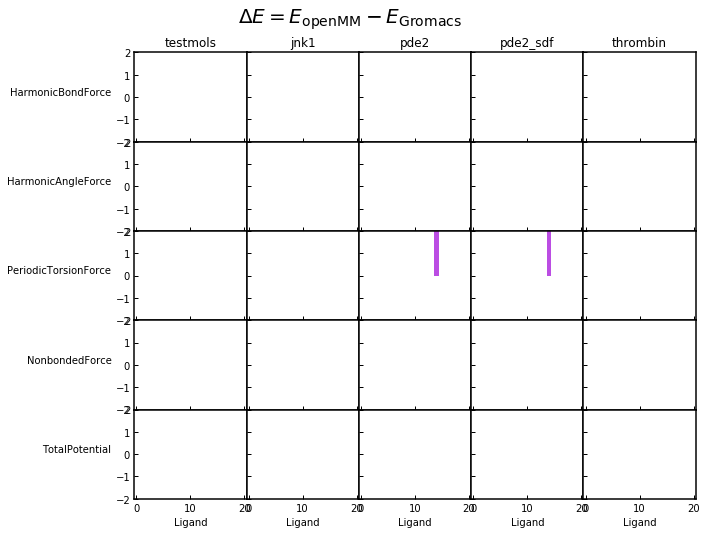

In [35]:
mpld3.enable_notebook()

plt.rcParams['figure.figsize'] = [12, 8]

fig, ax = plt.subplots(5, 5, sharex=True, sharey=True)

for ti, (t, ldict) in enumerate(energies.items()):
    for li, (l, edict) in enumerate(ldict.items()):
        for ei, (e, ene) in enumerate(edict.items()):
            ax[ei][ti].bar(li, ene[2])
for a in ax:
    for aa in a:
        aa.set_ylim(-2,2)
for a, l in zip(ax[:,0], energies['jnk1']['lig_17124-1'].keys()):
    a.set_ylabel(l, rotation=0, ha='right')
for a, l in zip(ax[-1,:], energies.keys()):
    a.set_xlabel('Ligand', rotation=0)
    #a.set_xticklabels(energies[l].keys())
for a, l in zip(ax[0,:], energies.keys()):
    a.set_title(l, rotation=0)
plt.gcf().suptitle('$\Delta E=E_{\mathrm{openMM}}-E_{\mathrm{Gromacs}}$', fontsize=20)
plt.savefig('energy_differences_openmm_gromacs.png')
plt.show()

#### Molecules with deviation > 0.01 kJ/mol in one of the terms

=== pde2 ===
------------------------------------------------------------
--- lig_49582390 ---
------------------------------------------------------------
    HarmonicBondForce   :     5.80769e+01        5.80770e+01       -1.33177e-04
    HarmonicAngleForce  :     1.40846e+02        1.40845e+02        5.02085e-04
    PeriodicTorsionForce:     1.83800e+02        8.27378e+01        1.01062e+02
    NonbondedForce      :     2.54969e+02        2.54969e+02       -4.67503e-04
    TotalPotential      :     6.37691e+02        6.37691e+02        3.53888e-04
=== pde2_sdf ===
------------------------------------------------------------
--- lig_49582390 ---
------------------------------------------------------------
    HarmonicBondForce   :     5.70546e+01        5.70548e+01       -2.06148e-04
    HarmonicAngleForce  :     1.39793e+02        1.39793e+02        1.91357e-05
    PeriodicTorsionForce:     1.83867e+02        8.27818e+01        1.01085e+02
    NonbondedForce      :     2.54101e+02   

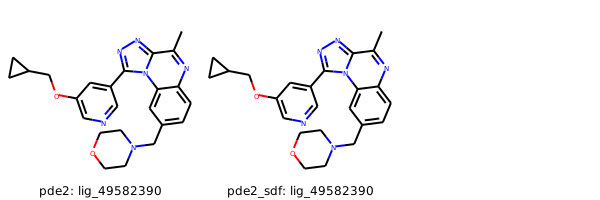

In [36]:
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
import rdkit.Chem.Draw as D
rdkitMols = []
for i, (target, ligand) in enumerate(np.unique(differing_molecules, axis=0)):
    print('=' * 60)
    print('=== ' + target + ' ===')
    print('=' * 60)
    ligPath = 'systems/' + target + '/' + ligand + '/' + ligand
        
    if os.path.isfile(ligPath+'.sdf'):
        print('-' * 60)
        print('--- ' + ligand + ' ---')
        print('-' * 60)
        mols = AllChem.SDMolSupplier(ligPath+'.sdf')
        for mol in mols:
            AllChem.Compute2DCoords(mol)
            mol.SetProp('_Name', target + ': ' + ligand)
            rdkitMols.append(mol)
    for k, item in energies[target][ligand].items():
        print('    {:20s}: {:15.5e}    {:15.5e}    {:15.5e}'.format(k, item[0], item[1], item[2]))
Draw.MolsToGridImage(rdkitMols, legends=[x.GetProp('_Name') for x in rdkitMols])

#### Minimized Energies

In [37]:
minEnergies={}
print('    {:20s}: {:15s}    {:15s}    {:15s}'.format('Energy contrib', 'openMM', 'Gromacs', 'Difference'))
for target in ['testmols', 'jnk1', 'pde2', 'pde2_sdf', 'thrombin']:
    print('=== ' + target + ' ===')
    minEnergies[target] = {}
    for key in openmmMinimizedEnergies[target].keys():
        print(key)
        minEnergies[target][key] = {}
        for kk, ene in openmmMinimizedEnergies[target][key].items():
            if kk == "NonbondedForce":
                gromacs_ene = sum([gromacsMinimizedEnergies[target][key][x] for x in ['LJ-14', 'Coulomb-14', 'LJ (SR)', 'Coulomb (SR)']])
            elif kk == 'PeriodicTorsionForce':
                gromacs_ene = gromacsMinimizedEnergies[target][key]['Proper Dih.']
                if 'Improper Dih.' in gromacsMinimizedEnergies[target][key].keys():
                    print('    {:20s}: {:8.2f}    {:8.2f}    {:8.2f}'.format('ImproperTorsionForce', 0.0, gromacsMinimizedEnergies[target][key]['Improper Dih.'], -gromacsMinimizedEnergies[target][key]['Improper Dih.']))
            elif kk == 'HarmonicAngleForce':
                gromacs_ene = gromacsMinimizedEnergies[target][key]['Angle']
            elif kk == 'HarmonicBondForce':
                gromacs_ene = gromacsMinimizedEnergies[target][key]['Bond']
            elif kk == 'TotalPotential':
                gromacs_ene = gromacsMinimizedEnergies[target][key]['Potential']
            else:
                print('Error: OpenMM Energy not known.')
            minEnergies[target][key][kk]=np.array([ene.value_in_unit(unit.kilojoules_per_mole), gromacs_ene, ene.value_in_unit(unit.kilojoules_per_mole)-gromacs_ene])
            print('    {:20s}: {:15.5e}    {:15.5e}    {:15.5e}'.format(kk, ene.value_in_unit(unit.kilojoules_per_mole), gromacs_ene, ene.value_in_unit(unit.kilojoules_per_mole)-gromacs_ene))

    Energy contrib      : openMM             Gromacs            Difference     
=== testmols ===
acetone
    HarmonicBondForce   :     3.14560e-02        1.11794e+00       -1.08648e+00
    HarmonicAngleForce  :     3.83691e-02        1.95430e+00       -1.91593e+00
    PeriodicTorsionForce:     2.00576e+01        2.20969e+01       -2.03930e+00
    NonbondedForce      :    -9.49103e+01       -9.28924e+01       -2.01791e+00
    TotalPotential      :    -7.47829e+01        0.00000e+00       -7.47829e+01
benzaldehyde
    HarmonicBondForce   :     9.57790e-01        1.66331e+00       -7.05520e-01
    HarmonicAngleForce  :     3.14087e-01        5.32816e-01       -2.18729e-01
    PeriodicTorsionForce:     1.25898e-04        1.31025e-02       -1.29766e-02
    NonbondedForce      :     5.43804e+01        5.52310e+01       -8.50595e-01
    TotalPotential      :     5.56524e+01        0.00000e+00        5.56524e+01
benzene
    HarmonicBondForce   :     4.94555e-01        2.58115e-01        2.3644

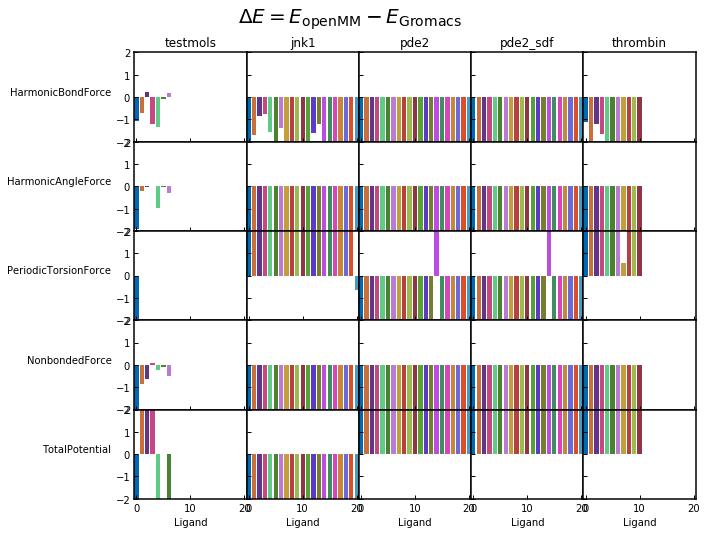

In [38]:
mpld3.enable_notebook()

plt.rcParams['figure.figsize'] = [12, 8]

fig, ax = plt.subplots(5, 5, sharex=True, sharey=True)

for ti, (t, ldict) in enumerate(minEnergies.items()):
    for li, (l, edict) in enumerate(ldict.items()):
        for ei, (e, ene) in enumerate(edict.items()):
            ax[ei][ti].bar(li, ene[2])
for a in ax:
    for aa in a:
        aa.set_ylim(-2,2)
for a, l in zip(ax[:,0], minEnergies['jnk1']['lig_17124-1'].keys()):
    a.set_ylabel(l, rotation=0, ha='right')
for a, l in zip(ax[-1,:], minEnergies.keys()):
    a.set_xlabel('Ligand', rotation=0)
    #a.set_xticklabels(energies[l].keys())
for a, l in zip(ax[0,:], energies.keys()):
    a.set_title(l, rotation=0)
plt.gcf().suptitle('$\Delta E=E_{\mathrm{openMM}}-E_{\mathrm{Gromacs}}$', fontsize=20)
plt.savefig('energy_minimized_differences_openmm_gromacs.png')
plt.show()

# Calculate RMSD between the minimized structures 
So far without roto-translational alignment

In [39]:
for target in ['testmols',  'jnk1', 'pde2', 'thrombin', 'pde2_sdf']:
    print('=' * 60)
    print('=== ' + target + ' ===')
    print('=' * 60)
    ligands = ! ls -d 'systems/'$target/*/
    for lig in ligands:
        lig = lig.split('/')
        ligPath = 'systems/' + target + '/' + lig[-2] + '/' + lig[-2]
        
        if os.path.isfile(ligPath+'_minimized.pdb') and os.path.isfile(ligPath+'_em.gro'):
            print('-' * 60)
            print('--- ' + lig[-2] + ' ---')
            print('-' * 60)
            gromacs_positions = pmd.load_file(ligPath+'_em.gro')
            openmm_positions = pmd.load_file(ligPath+'_minimized.pdb')
#             print(type(gromacs_positions.positions.value_in_unit(unit.nanometer)), type(openmm_positions.positions.value_in_unit(unit.nanometer)))
#             print(gromacs_positions.positions.value_in_unit(unit.nanometer), openmm_positions.positions.value_in_unit(unit.nanometer))
#             print(np.array(gromacs_positions.positions.value_in_unit(unit.nanometer))-np.array(openmm_positions.positions.value_in_unit(unit.nanometer)))
#             print(np.square(np.array(gromacs_positions.positions.value_in_unit(unit.nanometer))-np.array(openmm_positions.positions.value_in_unit(unit.nanometer))))
            squared_distances = np.sum(np.square(np.array(gromacs_positions.positions.value_in_unit(unit.nanometer))-np.array(openmm_positions.positions.value_in_unit(unit.nanometer))), axis = 1)
#             print(squared_distances)
            print('    RMSD: {:.4f} nm'.format(np.sqrt(squared_distances.sum()/squared_distances.shape[0])))  

=== testmols ===
------------------------------------------------------------
--- acetone ---
------------------------------------------------------------
    RMSD: 0.1554 nm
------------------------------------------------------------
--- benzaldehyde ---
------------------------------------------------------------
    RMSD: 0.3031 nm
------------------------------------------------------------
--- benzene ---
------------------------------------------------------------
    RMSD: 0.2853 nm
------------------------------------------------------------
--- ethane ---
------------------------------------------------------------
    RMSD: 0.0012 nm
------------------------------------------------------------
--- ethanol ---
------------------------------------------------------------
    RMSD: 0.2081 nm
------------------------------------------------------------
--- methane ---
------------------------------------------------------------
    RMSD: 0.0005 nm
-------------------------------

------------------------------------------------------------
--- lig_1a ---
------------------------------------------------------------
    RMSD: 0.1489 nm
------------------------------------------------------------
--- lig_1b ---
------------------------------------------------------------
    RMSD: 0.1525 nm
------------------------------------------------------------
--- lig_1c ---
------------------------------------------------------------
    RMSD: 0.1498 nm
------------------------------------------------------------
--- lig_1d ---
------------------------------------------------------------
    RMSD: 0.1073 nm
------------------------------------------------------------
--- lig_3a ---
------------------------------------------------------------
    RMSD: 0.1694 nm
------------------------------------------------------------
--- lig_3b ---
------------------------------------------------------------
    RMSD: 0.1953 nm
----------------------------------------------------------